In [ ]:
from IPython.display import Image

합성곱 GAN 과 바서슈타인 GAN 으로 합성 이미지 품질 높이기

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_09.png', width=700)

배치정규화

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_11.png', width=700)

생성자와 판별자

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_12.png', width=700)

In [ ]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch17/figures/17_13.png', width=700)

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import torch.nn as nn
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [21]:
import torchvision
from torchvision import transforms

image_path = './'
transfom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transfom,download=True)

batch_size = 64
torch.manual_seed(1)

from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,shuffle=True,drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 286089780.38it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25610083.26it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 189471285.63it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20550732.22it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
def make_generator_network(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(input_size, n_filters*4, 4,1,0,bias=False),
      nn.BatchNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*4, n_filters*2,3,2,1,bias=False),
      nn.BatchNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*2, n_filters,4,2,1,bias=False),
      nn.BatchNorm2d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters, 1,4,2,1, bias=False),
      nn.Tanh()
  )
  return model

class Discriminator(nn.Module):
  def __init__(self,n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1,n_filters, 4,2,1,bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters, n_filters*2,4,2,1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*2, n_filters*4,3,2,1, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*4,1,4,1,0,bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    output = self.network(input)
    return output.view(-1,1).squeeze(0)

In [ ]:
z_size = 100
image_size = (28,28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
# 손실함수와 옵티마이져
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(),0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [23]:
def create_noise(batch_size, z_size,mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size,1,1)*2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size,1,1)
  return input_z

In [ ]:
# 판별자 훈련
def d_train(x):
  disc_model.zero_grad()
    # 진짜 배치에서 판별자 훈련
  batch_size = x.size(0)
  x = x.to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)

  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # 가짜 배치에서 판별자 훈련
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # 그레이디언트 역전파와 판별자 파라미터 최적화
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
# 생성자 훈련
def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones((batch_size,1),device=device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)

  # 그레이디언트 역전파와 생성자 파라미터 최적화
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [25]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'에포크 {epoch:03d} | 평균 손실 >>'
          f' 생성자/판별자 {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

NameError: name 'd_train' is not defined

In [ ]:

# 시각화를 위해서 수집한 변수를 저장하고 불러오기
saved_variables = {
    'epoch_samples': epoch_samples,
    'd_losses': d_losses,
    'g_losses': g_losses
}
torch.save(saved_variables,'/content/drive/MyDrive/saved_variables2,pth')


# 판별자 모델
torch.save(disc_model,'/content/drive/MyDrive/disc_model2.pth')
 # 생성자 모델
torch.save(gen_model,'/content/drive/MyDrive/gen_model2.pth')

In [6]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")

# 불러오기
loaded_variables = torch.load('/content/drive/MyDrive/saved_variables2,pth')
# 각 변수를 불러오기
epoch_samples = loaded_variables['epoch_samples']
d_losses = loaded_variables['d_losses']
g_losses = loaded_variables['g_losses']
# 판별자 생성자 모델 불러오기
disc_model = torch.load('/content/drive/MyDrive/disc_model2.pth')
gen_model = torch.load('/content/drive/MyDrive/gen_model2.pth')

device : cuda


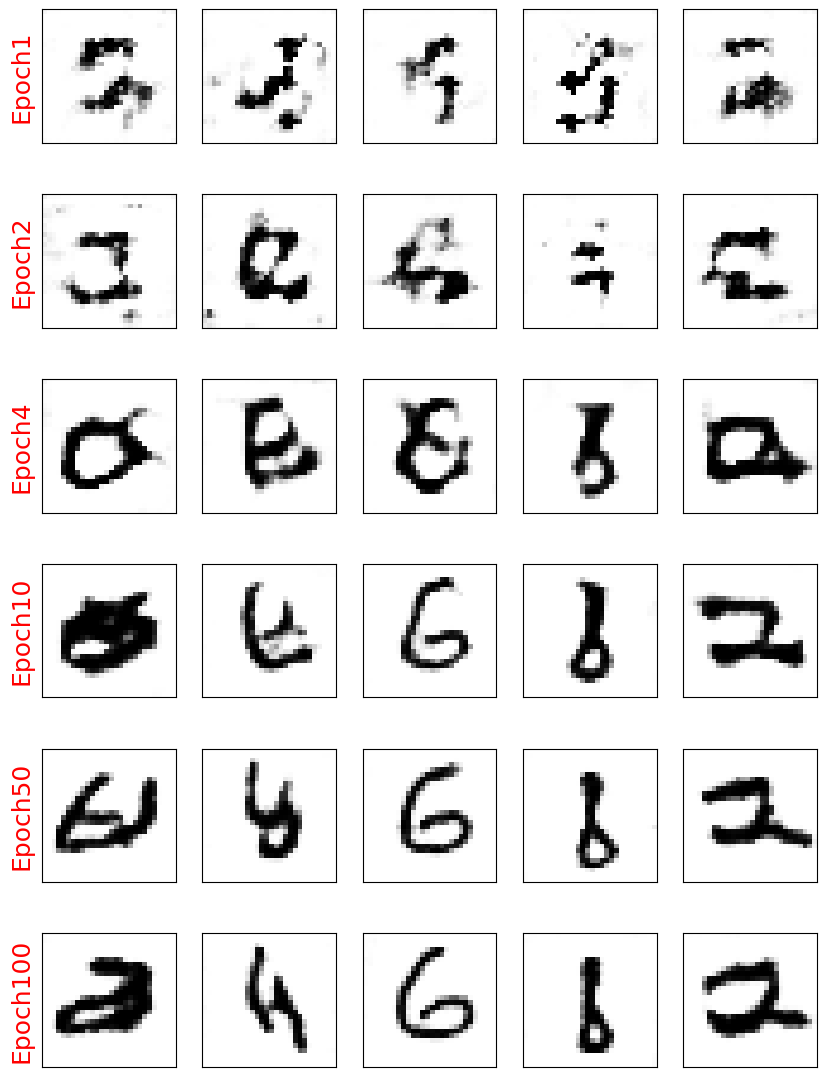

In [8]:
import matplotlib.pyplot as plt

selected_epochs = [1,2,4,10,50,100]
fig = plt.figure(figsize=(10,14))
for i, e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6,5, i*5 + j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j== 0:
      ax.text(-0.06,0.5,f'Epoch{e}', rotation=90, size=18, color='red', horizontalalignment='right',verticalalignment='center',transform=ax.transAxes  )
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')
plt.show()

In [9]:
# GAN에 EM 거리 사용
# 그레이디언트 페널티
# WGAN-GP 로 DCGAN 모델 훈련

In [14]:
def make_generator_network_wgan(input_size, n_filters):
  model = nn.Sequential(
      nn.ConvTranspose2d(input_size, n_filters*4, 4,1,0,bias=False),
      nn.InstanceNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*4, n_filters*2,3,2,1,bias=False),
      nn.InstanceNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*2, n_filters, 4,2,1,bias=False),
      nn.InstanceNorm2d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters,1,4,2,1,bias=False),
      nn.Tanh()
  )
  return model

import torch.nn as nn

class DiscriminatorWGAN(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, n_filters,4,2,1,bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters, n_filters*2, 4,2,1,bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*2, n_filters*4, 3,2,1,bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*4,1,4,1,0,bias=False),
        nn.Sigmoid()
    )
  def forward(self, input):
    output = self.network(input)
    return output.view(-1,1).squeeze(0)

In [15]:
z_size = 100
image_size = (28,28)
n_filters = 32\

gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(),0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [16]:
# 보간기법으로 성능향상
from torch.autograd import grad as torch_grad

In [17]:
def gradient_penalty(real_data, generated_data):
  batch_size = real_data.size(0)
  #보간 계산
  alpha = torch.rand(real_data.shape[0],1,1,1, requires_grad=True, device=device)
  interpolated = alpha * real_data + (1 - alpha) * generated_data

  #보간된 샘플의 확률 계산
  proba_interpolated = disc_model(interpolated)

  # 샘플에 대한 확률의 그레이디언트 계산
  gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

  gradients = gradients.view(batch_size, -1)
  gradients_norm = gradients.norm(2, dim=1)
  return lambda_gp * ((gradients_norm - 1)**2).mean()


In [18]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # 진짜 데이터와 생성된 데이터의 확률 계산
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()

In [19]:
#  생성자 훈련
def g_train_wgan(x):
  gen_model.zero_grad()

  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_generated = disc_model(g_output)
  g_loss = -d_generated.mean()

  # 그레이디언트 역전파와 생성자 파라미터 최적화
  g_loss.backward()
  g_optimizer.step()
  return g_loss.data.item()

In [ ]:
epoch_sample_wgan = []
lambda_gp = 10.0
num_epochs = 20
torch.manual_seed(1)
ciritic_iterations = 5

for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses = [],[]
  for i, (x, _) in enumerate(mnist_dl):
    for _ in range(ciritic_iterations):
      d_loss = d_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(d_train_wgan(x))
  print(f'에포크 {epoch:03d} | 판별자 손실 >> {torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_sample_wgan.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

에포크 001 | 판별자 손실 >> -0.7477
에포크 002 | 판별자 손실 >> -0.7583
에포크 003 | 판별자 손실 >> -0.7627
